<a href="https://colab.research.google.com/github/vanshitak/ML-Projects/blob/main/classification_of_legal_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classifying Legal Documents by their Title**

Install dependencies

In [ ]:
pip install datasets

In [ ]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.0 MB/s eta 0:00:00


Import required libraries

In [ ]:
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt

In [ ]:
import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Load the dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("pietrolesci/eurlex-57k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
print(type(dataset))
print(dataset)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['celex_id', 'document_type', 'title', 'header', 'recitals', 'main_body', 'eurovoc_concepts', 'text', 'uid'],
        num_rows: 45000
    })
    validation: Dataset({
        features: ['celex_id', 'document_type', 'title', 'header', 'recitals', 'main_body', 'eurovoc_concepts', 'text', 'uid'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['celex_id', 'document_type', 'title', 'header', 'recitals', 'main_body', 'eurovoc_concepts', 'text', 'uid'],
        num_rows: 6000
    })
})


Prepare the dataset

In [ ]:
selected_col = ['title','document_type']

train_df = dataset['train'].to_pandas()[selected_col]
validation_df = dataset['validation'].to_pandas()[selected_col]
test_df = dataset['test'].to_pandas()[selected_col]

print("Train DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(validation_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
                                               title document_type
0  Commission Implementing Regulation (EU) No 727...    Regulation
1  Regulation (EEC) No 2481/75 of the Council of ...    Regulation
2  2010/8/EU, Euratom: Commission Decision of 22 ...      Decision
3  82/211/EEC: Commission Decision of 17 March 19...      Decision
4  96/84/Euratom, ECSC, EC: Commission Decision o...      Decision

Validation DataFrame:
                                               title document_type
0  Council Regulation (EC) No 1400/1999 of 24 Jun...    Regulation
1  Commission Implementing Regulation (EU) No 381...    Regulation
2  Council Joint Action 2007/732/CFSP of 13 Novem...      Decision
3  Commission Regulation (EEC) No 2239/91 of 26 J...    Regulation
4  Commission Regulation (EC) No 2007/95 of 18 Au...    Regulation

Test DataFrame:
                                               title document_type
0  Commission Implementing Decision of 14 October...      Decision
1  Co

In [ ]:
def map_type(document_type):
    if document_type == 'Regulation':
        return 0
    elif document_type == 'Decision':
        return 1
    elif document_type == 'Directive':
        return 2
    else:
        return -1

In [ ]:
train_df['type'] = train_df['document_type'].apply(map_type)
validation_df['type'] = validation_df['document_type'].apply(map_type)
test_df['type'] = test_df['document_type'].apply(map_type)

print("Train DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(validation_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
                                               title document_type  type
0  Commission Implementing Regulation (EU) No 727...    Regulation     0
1  Regulation (EEC) No 2481/75 of the Council of ...    Regulation     0
2  2010/8/EU, Euratom: Commission Decision of 22 ...      Decision     1
3  82/211/EEC: Commission Decision of 17 March 19...      Decision     1
4  96/84/Euratom, ECSC, EC: Commission Decision o...      Decision     1

Validation DataFrame:
                                               title document_type  type
0  Council Regulation (EC) No 1400/1999 of 24 Jun...    Regulation     0
1  Commission Implementing Regulation (EU) No 381...    Regulation     0
2  Council Joint Action 2007/732/CFSP of 13 Novem...      Decision     1
3  Commission Regulation (EEC) No 2239/91 of 26 J...    Regulation     0
4  Commission Regulation (EC) No 2007/95 of 18 Au...    Regulation     0

Test DataFrame:
                                               title document_type 

In [ ]:
train_df.drop(columns=['document_type'], inplace=True)
validation_df.drop(columns=['document_type'], inplace=True)
test_df.drop(columns=['document_type'], inplace=True)

print("Train DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(validation_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
                                               title  type
0  Commission Implementing Regulation (EU) No 727...     0
1  Regulation (EEC) No 2481/75 of the Council of ...     0
2  2010/8/EU, Euratom: Commission Decision of 22 ...     1
3  82/211/EEC: Commission Decision of 17 March 19...     1
4  96/84/Euratom, ECSC, EC: Commission Decision o...     1

Validation DataFrame:
                                               title  type
0  Council Regulation (EC) No 1400/1999 of 24 Jun...     0
1  Commission Implementing Regulation (EU) No 381...     0
2  Council Joint Action 2007/732/CFSP of 13 Novem...     1
3  Commission Regulation (EEC) No 2239/91 of 26 J...     0
4  Commission Regulation (EC) No 2007/95 of 18 Au...     0

Test DataFrame:
                                               title  type
0  Commission Implementing Decision of 14 October...     1
1  Commission Regulation (EC) No 2052/96 of 25 Oc...     0
2  Commission Regulation (EC) No 1868/2001 of 24 ...     0

In [ ]:
df_count = train_df.groupby(['type'], as_index = False).agg({'title': 'count'})
df_count.head()

,type,title
0,0,29600
1,1,13627
2,2,1773


In [ ]:
df_count = test_df.groupby(['type'], as_index = False).agg({'title': 'count'})
df_count.head()

,type,title
0,0,3967
1,1,1793
2,2,240


In [ ]:
df_count = validation_df.groupby(['type'], as_index = False).agg({'title': 'count'})
df_count.head()

,type,title
0,0,3964
1,1,1819
2,2,217


Preprocess the text

In [ ]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_slash_with_space(text):
    return text.replace('\\', " ")

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def text_lowercase(text):
    return text.lower()

def remove_whitespace(text):
    return  " ".join(text.split())

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stems)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return ' '.join(lemmas)

In [ ]:
def perform_preprocessing(text):
    #text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    #text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

In [ ]:
train_df['title'] = train_df['title'].apply(perform_preprocessing)
train_df.head()

,title,type
0,commission implement regulation eu no june ini...,0
1,regulation eec no council september amend regu...,0
2,eu euratom commission decision december declin...,1
3,eec commission decision march establish jodon ...,1
4,euratom ecsc ec commission decision january ad...,1


In [ ]:
test_df['title'] = test_df['title'].apply(perform_preprocessing)
test_df.head()

validation_df['title'] = validation_df['title'].apply(perform_preprocessing)
validation_df.head()

,title,type
0,council regulation ec no june fix target price...,0
1,commission implement regulation eu no april de...,0
2,council joint action cfsp november amend joint...,1
3,commission regulation eec no july transitional...,0
4,commission regulation ec no august rectify cer...,0


In [ ]:
x_train = train_df['title']
x_test = test_df['title']
x_val = validation_df['title']
y_train = train_df['type']
y_test = test_df['type']
y_val = validation_df['type']

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train)
X_train_count =  count_vect.transform(x_train)
X_test_count =  count_vect.transform(x_test)

In [ ]:
print(X_train_count.shape)
print(X_test_count.shape)

(45000, 11635)
(6000, 11635)


Set up word vectors

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train)
X_train_tfidf =  tfidf_vect.transform(x_train)
X_test_tfidf =  tfidf_vect.transform(x_test)

In [ ]:
print(X_train_tfidf.shape)

(45000, 5000)


In [ ]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(x_train)
X_train_ngram = tfidf_vect_ngram.transform(x_train)
X_test_ngram = tfidf_vect_ngram.transform(x_test)

In [ ]:
print(X_train_ngram.shape)

(45000, 5000)


In [ ]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train)
X_train_chars =  tfidf_vect_ngram_chars.transform(x_train)
X_test_chars =  tfidf_vect_ngram_chars.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
print(X_train_chars.shape)

(45000, 5000)


In [ ]:
print(y_train.shape,y_test.shape)

(45000,) (6000,)


Test different Models

In [ ]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(y_test, predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

NB, Count Vectors:  0.9753333333333334
NB, WordLevel TF-IDF:  0.9535
NB, N-Gram Vectors:  0.9823333333333333
NB, CharLevel Vectors:  0.9616666666666667


<BarContainer object of 4 artists>

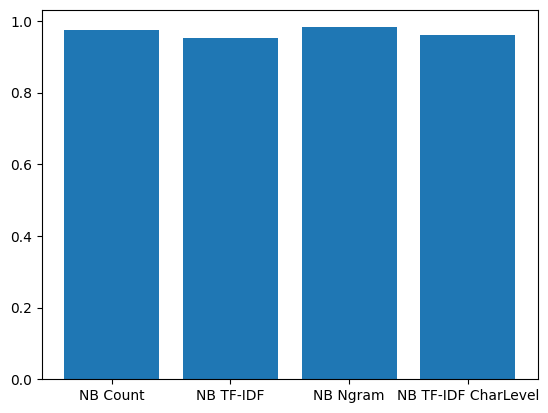

In [ ]:
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_ngram, y_train, X_test_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_chars, y_train, X_test_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

LR, Count Vectors:  0.9995
LR, WordLevel TF-IDF:  0.9986666666666667
LR, N-Gram Vectors:  0.9995
LR, CharLevel Vectors:  0.9988333333333334


<BarContainer object of 4 artists>

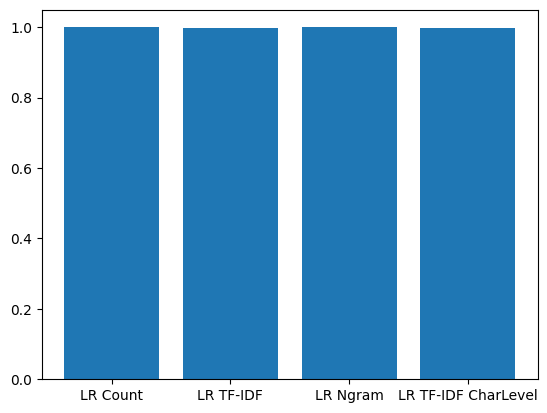

In [ ]:
accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), X_train_ngram, y_train, X_test_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), X_train_chars, y_train, X_test_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

In [ ]:
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

RF, Count Vectors:  0.9993333333333333
RF, WordLevel TF-IDF:  0.9991666666666666


Visualize results of the best model

In [ ]:
#logistic Regression with N-gram tf-idf vectors
lr_ngram_model = linear_model.LogisticRegression()
lr_ngram_model.fit(X_train_ngram, y_train)

LogisticRegression()

In [ ]:
y_train_pred = lr_ngram_model.predict(X_train_ngram)
y_test_pred = lr_ngram_model.predict(X_test_ngram)

train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
print("Accuracy on Train Data:", train_accuracy)

test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Data:", test_accuracy)

Accuracy on Train Data: 0.9997555555555555
Accuracy on Test Data: 0.9995


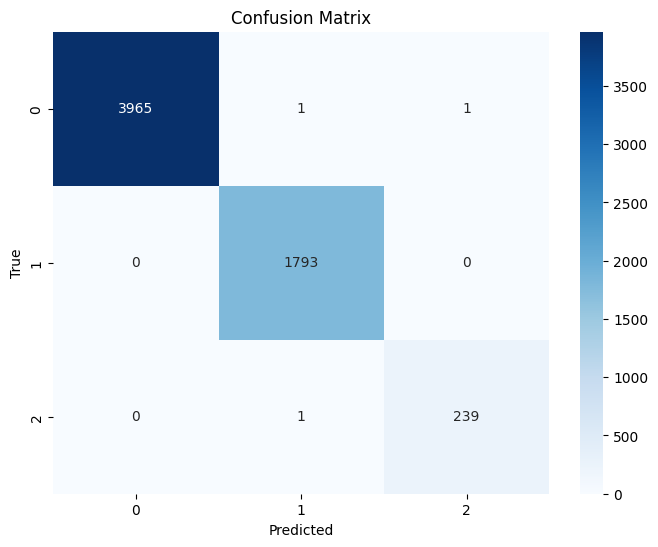

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lr_ngram_model.classes_, yticklabels=lr_ngram_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
x_val_ngram = tfidf_vect_ngram.transform(x_val)

In [ ]:
y_val_pred = lr_ngram_model.predict(x_val_ngram)
val_accuracy =  metrics.accuracy_score(y_val, y_val_pred)
print("Accuracy on Train Data:", val_accuracy)

Accuracy on Train Data: 0.9996666666666667


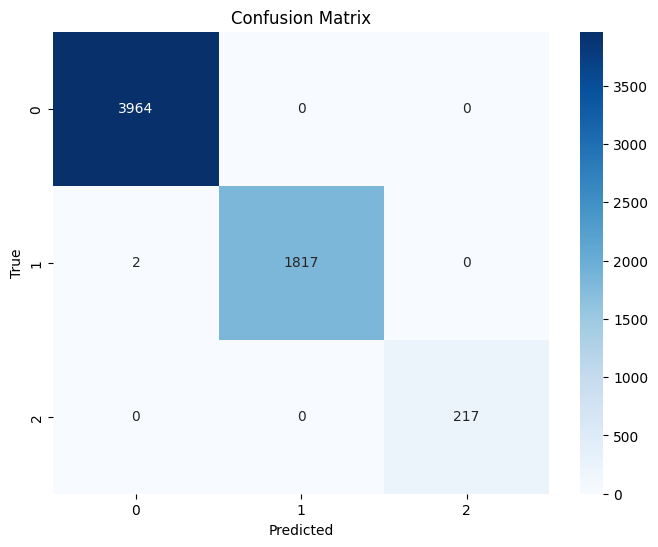

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lr_ngram_model.classes_, yticklabels=lr_ngram_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Save the model

In [ ]:
import joblib

In [ ]:
model_filename = 'logistic_regression_model.pkl'
joblib.dump(lr_ngram_model, model_filename)
print("Model saved as", model_filename)

Model saved as logistic_regression_model.pkl
